In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import numpy as np
import glob
mpl.style.use('seaborn-talk')


In [2]:
# base_dir = '.'
base_dir = './May-5-Take2'
# base_dir = './May12SynradExport'
# base_dir = './May12SynradExport-Take2'

In [3]:
df_flux = pd.read_excel(os.path.join(base_dir, 'Flux per facet.xlsx')  )

df_flux.set_index('Facet', inplace=True)

df_flux

,Flux (on facet)
Facet,
18952,2150000000000000
18953,1720000000000000
18954,1450000000000000
18955,1300000000000000
18956,1180000000000000
18957,1100000000000000
18958,1060000000000000
18959,1100000000000000
18960,1170000000000000


In [4]:
# df_flux.loc[ 18985 , 'Flux (on facet)' ]

In [5]:
df_facets = pd.DataFrame()

In [6]:
filenames = glob.glob(os.path.join(base_dir, "./*.csv"))
print(len(filenames))
dfs = []

df_facets

cnt = 0;
for filename in filenames:
    cnt = cnt +1
    
    filename_base = os.path.basename(filename)
    try:
        facet_id = int(filename_base.split('.')[0]);
    except :
        print(f'Skip {filename_base}')
        continue;
        
    flux = df_flux.loc[ facet_id , 'Flux (on facet)' ]
    
    
    df = pd.read_csv(filename)
    scale = flux / df['Flux_[photon/s]'].sum();
    df['Flux_Normalized'] = df.apply(lambda x: x['Flux_[photon/s]'] * scale , axis =1)
    
    phi_average = np.arctan2(df['Pos_Y_[cm]'].mean(),df['Pos_X_[cm]'].mean())
    
    print(f'{cnt}: facet {facet_id} | <phi> = {phi_average} ->{filename} @ {flux:.2e} photon/s, scale = {scale}')
    
    df_facets = df_facets.append(
        {'Facet':facet_id, 
         'Flux': flux, 
#          'Power': df_flux.loc[ facet_id , 'Power (on facet)'],
         'Phi':phi_average}, ignore_index=True)
    
    dfs.append(df)
    

big_frame = pd.concat(dfs, ignore_index=True, sort=False)

37
1: facet 18952 | <phi> = 2.5346998031800037 ->./May-5-Take2/./18952.csv @ 2.15e+15 photon/s, scale = 0.0004015345090833864
2: facet 18953 | <phi> = 2.3586784268201213 ->./May-5-Take2/./18953.csv @ 1.72e+15 photon/s, scale = 0.00032090850107137895
3: facet 18954 | <phi> = 2.183412902810806 ->./May-5-Take2/./18954.csv @ 1.45e+15 photon/s, scale = 0.0002705156971718889
4: facet 18955 | <phi> = 2.008030482288991 ->./May-5-Take2/./18955.csv @ 1.30e+15 photon/s, scale = 0.00024238279482846801
5: facet 18956 | <phi> = 1.83360639947941 ->./May-5-Take2/./18956.csv @ 1.18e+15 photon/s, scale = 0.00021986736215960076
6: facet 18957 | <phi> = 1.6585952600173566 ->./May-5-Take2/./18957.csv @ 1.10e+15 photon/s, scale = 0.000204966241903504
7: facet 18958 | <phi> = 1.484007121048324 ->./May-5-Take2/./18958.csv @ 1.06e+15 photon/s, scale = 0.0001976131370875735
8: facet 18959 | <phi> = 1.3079773073048995 ->./May-5-Take2/./18959.csv @ 1.10e+15 photon/s, scale = 0.00020512755914374727
9: facet 18960 

In [7]:

df_facets.set_index('Facet', inplace=True)
df_facets.to_csv(os.path.join(base_dir, 'Facet_CheckAll.csv'))
df_facets

,Flux,Phi
Facet,,
18952.0,2.150000e+15,2.534700
18953.0,1.720000e+15,2.358678
18954.0,1.450000e+15,2.183413
18955.0,1.300000e+15,2.008030
18956.0,1.180000e+15,1.833606
18957.0,1.100000e+15,1.658595
18958.0,1.060000e+15,1.484007
18959.0,1.100000e+15,1.307977
18960.0,1.170000e+15,1.133541


In [8]:
Phi = big_frame.apply(lambda x : np.arctan2(x['Pos_Y_[cm]'], x['Pos_X_[cm]']), axis=1)

Text(0, 0.5, 'Sum[Virtual photon]/arc Virtual photon/bin')

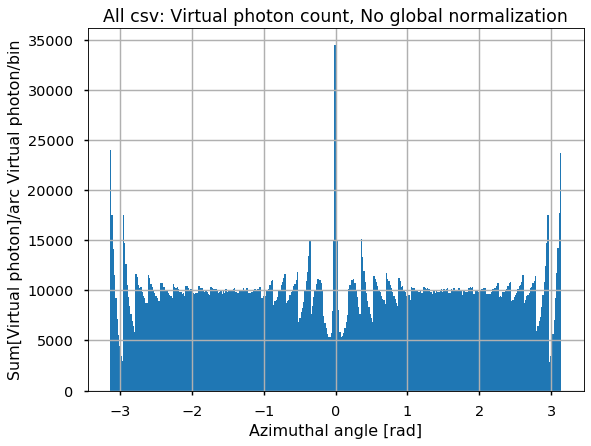

In [9]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
Phi.hist(bins=360)
plt.title('All csv: Virtual photon count, No global normalization')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Sum[Virtual photon]/arc Virtual photon/bin")

Text(0, 0.5, 'Sum[Flux]/arc photon/s/rad')

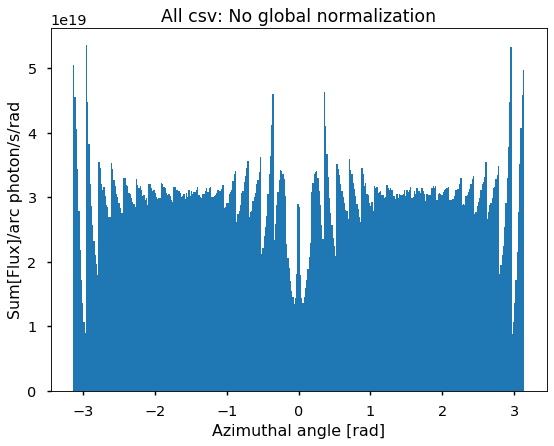

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame['Flux_[photon/s]'].to_numpy() / (2*np.pi/360) );
plt.title('All csv: No global normalization')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Sum[Flux]/arc photon/s/rad")

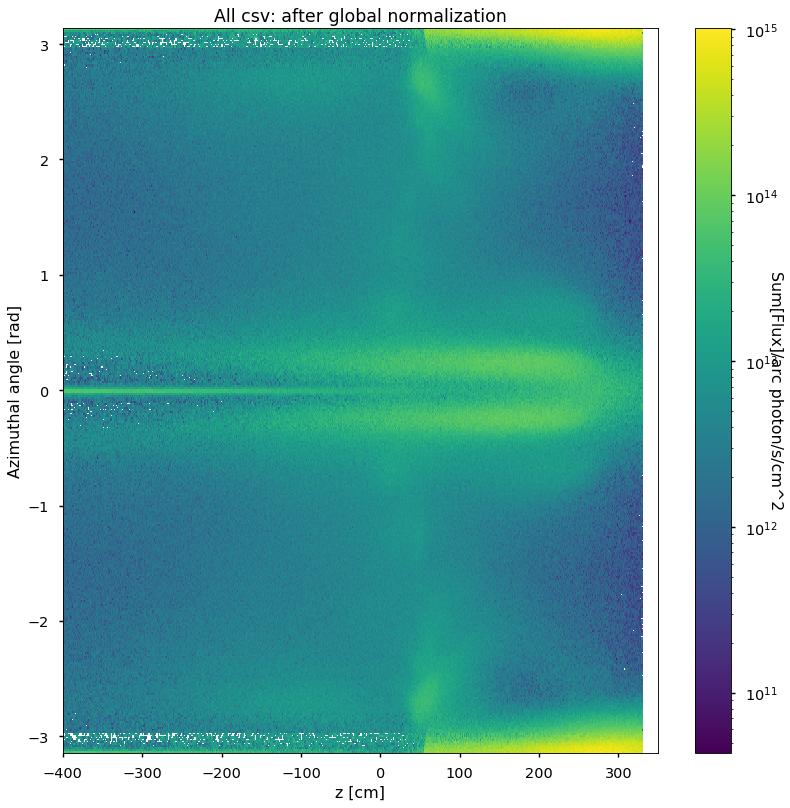

In [11]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
h = plt.hist2d(
    x = big_frame['Pos_Z_[cm]'],
    y = Phi.to_numpy(), 
    bins=[np.linspace(-400,350,num=750+1), np.linspace(-np.pi,np.pi,num=361) ] ,
    weights=big_frame['Flux_Normalized'].to_numpy() / (2*np.pi*2.9/360),
    norm=mpl.colors.LogNorm());
plt.title('All csv: after global normalization');
plt.xlabel("z [cm]");
plt.ylabel("Azimuthal angle [rad]");
cbar = plt.colorbar(h[3])
cbar.set_label('Sum[Flux]/arc photon/s/cm^2', rotation=270)


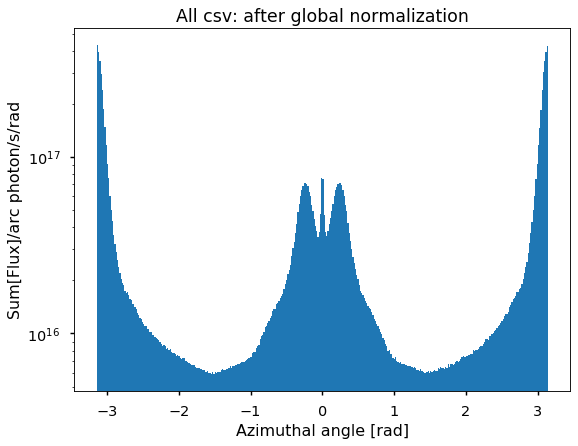

In [12]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame['Flux_Normalized'].to_numpy() / (2*np.pi/360),
    log = True );
plt.title('All csv: after global normalization');
plt.xlabel("Azimuthal angle [rad]");
plt.ylabel("Sum[Flux]/arc photon/s/rad");

Text(0, 0.5, 'Sum[Flux]/arc photon/s/rad')

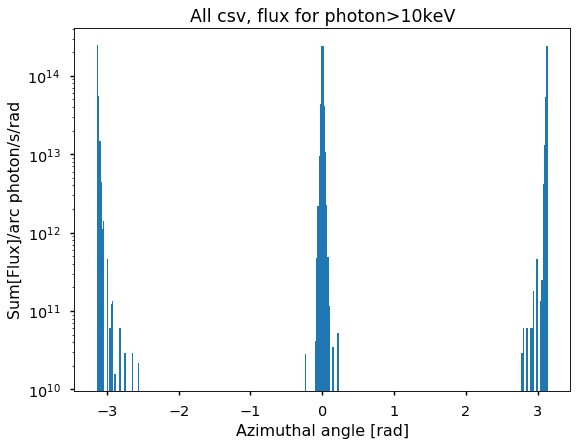

In [13]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3) * x['Flux_Normalized'], axis=1).to_numpy(),
    log = True);
plt.title('All csv, flux for photon>10keV')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Sum[Flux]/arc photon/s/rad")

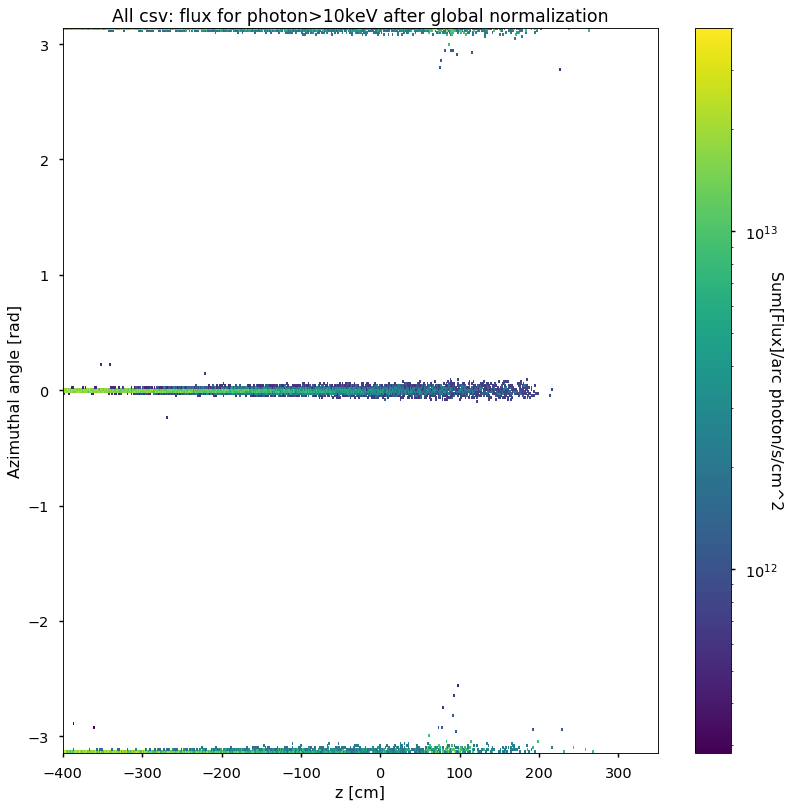

In [14]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
h = plt.hist2d(
    x = big_frame['Pos_Z_[cm]'],
    y = Phi.to_numpy(), 
    bins=[np.linspace(-400,350,num=750+1), np.linspace(-np.pi,np.pi,num=361) ] ,
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3) * x['Flux_Normalized'], axis=1).to_numpy() / (2*np.pi*2.9/360),
    norm=mpl.colors.LogNorm());
plt.title('All csv: flux for photon>10keV after global normalization');
plt.xlabel("z [cm]");
plt.ylabel("Azimuthal angle [rad]");
cbar = plt.colorbar(h[3])
cbar.set_label('Sum[Flux]/arc photon/s/cm^2', rotation=270)

Text(0, 0.5, 'Sum[Flux] photon/s/cm')

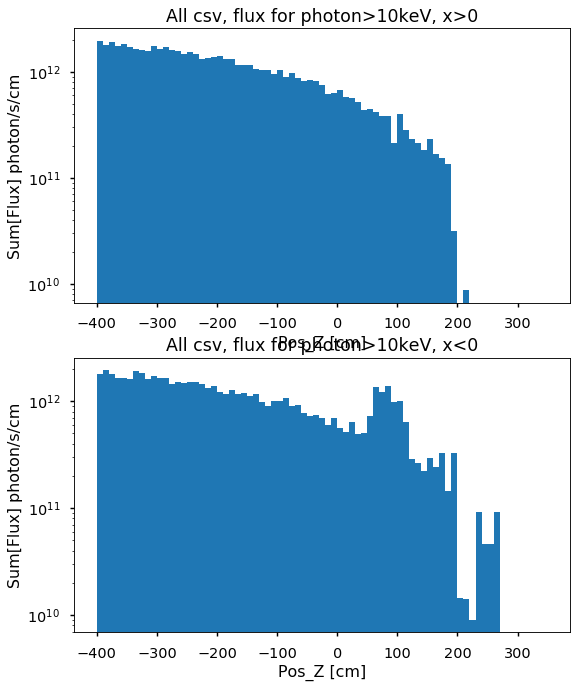

In [15]:
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 1, 1)
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']>0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True);
plt.title('All csv, flux for photon>10keV, x>0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] photon/s/cm")

plt.subplot(2, 1, 2)
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']<0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True);
plt.title('All csv, flux for photon>10keV, x<0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] photon/s/cm")

Text(0, 0.5, 'Sum[Flux] photon/s/cm')

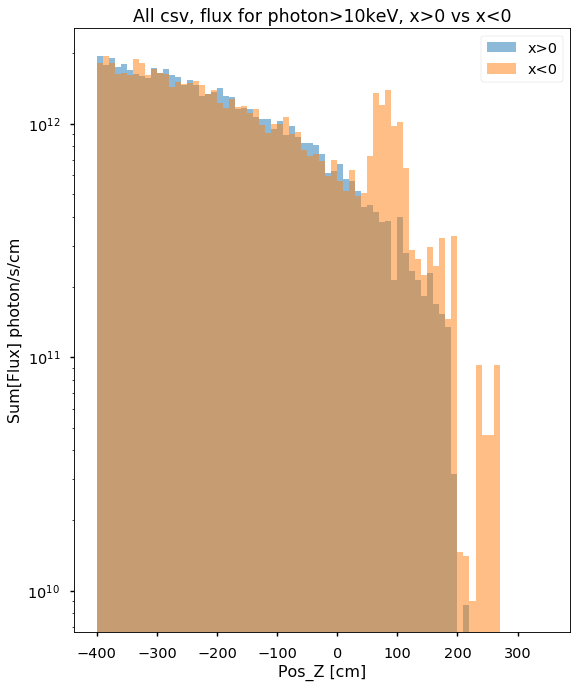

In [16]:
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')

plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']>0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True, label='x>0', alpha = 0.5, lw=3);
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']<0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True, label='x<0', alpha = 0.5, lw=3);
plt.legend()

plt.title('All csv, flux for photon>10keV, x>0 vs x<0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] photon/s/cm")

Text(0, 0.5, 'Sum[Flux] virtual photon/cm')

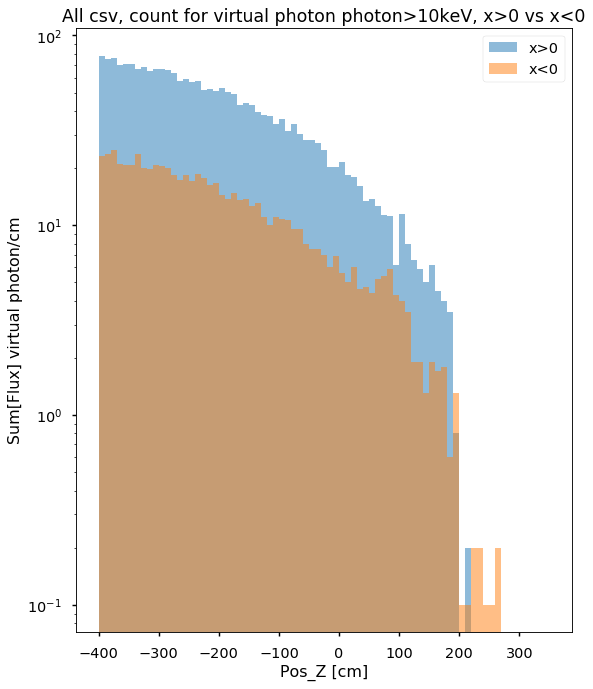

In [26]:
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')

plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']>0)  / 10, axis=1).to_numpy(),
    log = True, label='x>0', alpha = 0.5, lw=3);
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']<0)  / 10, axis=1).to_numpy(),
    log = True, label='x<0', alpha = 0.5, lw=3);
plt.legend()

plt.title('All csv, count for virtual photon photon>10keV, x>0 vs x<0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] virtual photon/cm")

Text(0, 0.5, 'Virtual photon count per bin')

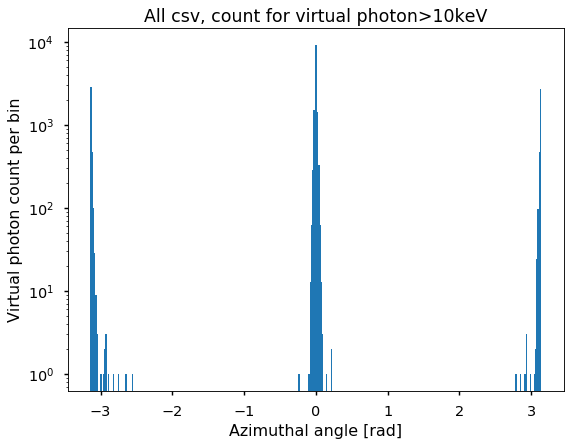

In [17]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3), axis=1).to_numpy(),
    log = True);
plt.title('All csv, count for virtual photon>10keV')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Virtual photon count per bin")

Text(0, 0.5, 'Virtual photon count per bin')

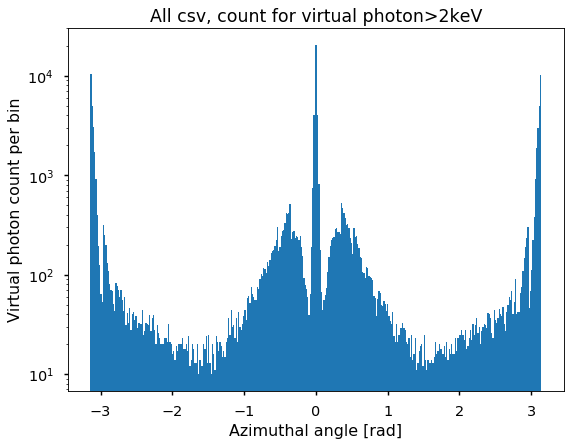

In [18]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>2e3), axis=1).to_numpy(),
    log = True);
plt.title('All csv, count for virtual photon>2keV')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Virtual photon count per bin")

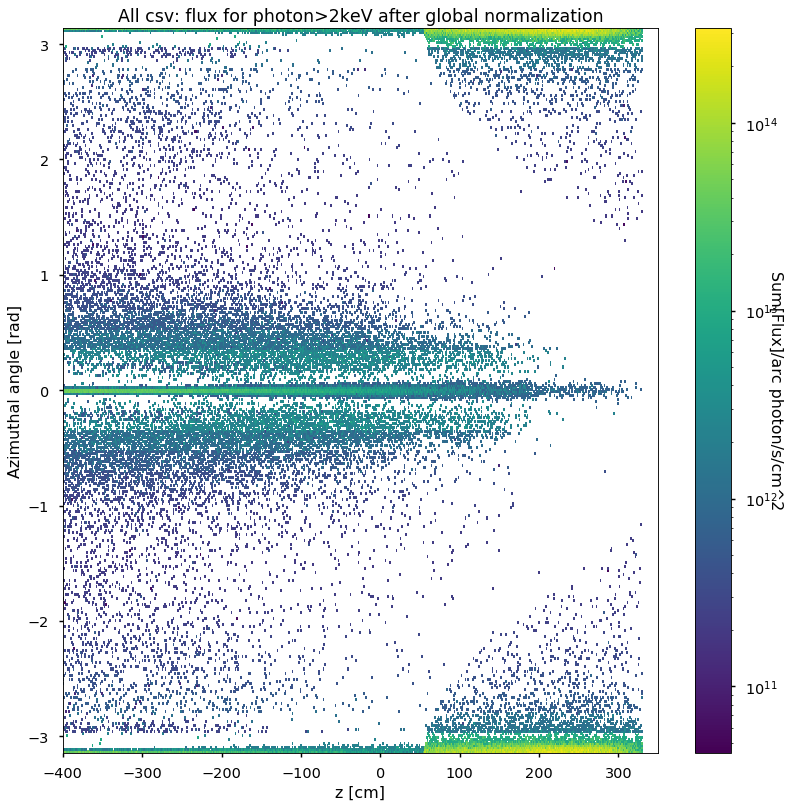

In [19]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
h = plt.hist2d(
    x = big_frame['Pos_Z_[cm]'],
    y = Phi.to_numpy(), 
    bins=[np.linspace(-400,350,num=750+1), np.linspace(-np.pi,np.pi,num=361) ] ,
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>2e3) * x['Flux_Normalized'], axis=1).to_numpy() / (2*np.pi*2.9/360),
    norm=mpl.colors.LogNorm());
plt.title('All csv: flux for photon>2keV after global normalization');
plt.xlabel("z [cm]");
plt.ylabel("Azimuthal angle [rad]");
cbar = plt.colorbar(h[3])
cbar.set_label('Sum[Flux]/arc photon/s/cm^2', rotation=270)


In [20]:
big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3), axis=1).sum()

28825

In [21]:
big_frame.apply(lambda x: int(x['Energy_[eV]']>2e3), axis=1).sum()

120900

In [22]:
# os.system('jupyter nbconvert --to html CheckAll.ipynb')
# os.system(f'mv CheckAll.html {base_dir}/')

In [25]:
# from time import sleep
# from IPython.display import display, Javascript
# import hashlib

# def save_notebook(file_path):
#     start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
#     display(Javascript('IPython.notebook.save_checkpoint();'))
#     current_md5 = start_md5

#     while start_md5 == current_md5:
#         sleep(1)
#         current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
        
#     print(f'saved to {file_path} {start_md5} -> {current_md5}');


# save_notebook('CheckAll.ipynb')
os.system('jupyter nbconvert --to html CheckAll.ipynb')
print(os.popen(f'mv -fv CheckAll.html {base_dir}/').read())


‘CheckAll.html’ -> ‘./May-5-Take2/CheckAll.html’

